# Hotel Price Prediction using Neural Networks

## Importing the libraries

In [237]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder


tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing the train and test data

### Splitting the targets from train and testdata

In [238]:
train_data = pd.read_csv('./data/trainingset.csv')
train_targets = train_data['ADR']
train_data.drop(columns=['ADR'], inplace=True)

test_data = pd.read_csv('./data/testset.csv')
test_targets = test_data['ADR']
test_data.drop(columns=['ADR'], inplace=True)


In [239]:
train_data.shape, test_data.shape

((40060, 27), (79330, 27))

### Replace the missing values with the mean of the column

In [240]:
train_data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
DaysInWaitingList                0
CustomerType                     0
RequiredCarParkingSpaces         0
TotalOfSpecialRequests           0
ReservationStatus                0
dtype: int64

In [241]:
train_data['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: Country, Length: 125, dtype: int64

In [242]:
train_data['Country'][train_data['Country'].isna()]

30       NaN
4127     NaN
7092     NaN
7860     NaN
8779     NaN
        ... 
26473    NaN
28460    NaN
31085    NaN
31594    NaN
33087    NaN
Name: Country, Length: 464, dtype: object

In [243]:
train_data['Country'].fillna('PRT', inplace=True)

In [244]:
train_data.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64

In [245]:
test_data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
DaysInWaitingList               0
CustomerType                    0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationStatus               0
dtype: int64

In [246]:
test_data['Children'].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [247]:
test_data['Country'].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [248]:
test_data['Children'].fillna(0, inplace=True)
test_data['Country'].fillna('PRT', inplace=True)

### Encoding the categorical data on training set

In [249]:
train_data.dtypes

IsCanceled                      int64
LeadTime                        int64
ArrivalDateYear                 int64
ArrivalDateMonth               object
ArrivalDateWeekNumber           int64
ArrivalDateDayOfMonth           int64
StaysInWeekendNights            int64
StaysInWeekNights               int64
Adults                          int64
Children                        int64
Babies                          int64
Meal                           object
Country                        object
MarketSegment                  object
DistributionChannel            object
IsRepeatedGuest                 int64
PreviousCancellations           int64
PreviousBookingsNotCanceled     int64
ReservedRoomType               object
AssignedRoomType               object
BookingChanges                  int64
DepositType                    object
DaysInWaitingList               int64
CustomerType                   object
RequiredCarParkingSpaces        int64
TotalOfSpecialRequests          int64
ReservationS

In [250]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

In [251]:
# train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
# test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)


encoders_list = {col: OneHotEncoder() for col in categorical_columns}

for col in categorical_columns:
    enocded_column = encoders_list[col].fit_transform(
        train_data[[col]])
    train_data = pd.concat([train_data, pd.DataFrame(
        enocded_column.toarray(),
        columns=encoders_list[col].categories_)], axis=1)

    train_data.drop(columns=[col], inplace=True)

#     test_data = pd.concat([test_data, pd.DataFrame(encoders_list[i].transform(
#         test_data[[categorical_columns[i]]]).toarray(),
#         columns=encoders_list[i].categories_)], axis=1)

#     test_data.drop(columns=[col], inplace=True)


In [252]:
train_data.shape

(40060, 200)

### Converting the data and targets into tensors

In [253]:
train_data = tf.convert_to_tensor(train_data.values,
                                        dtype=tf.float64)
train_targets = tf.convert_to_tensor(train_targets.values,
                                     dtype=tf.float64)


In [254]:
train_data.shape

TensorShape([40060, 200])

In [255]:
train_targets.shape

TensorShape([40060])

In [256]:
train_data.device, train_targets.device

('/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [257]:
train_data.dtype, train_targets.dtype

(tf.float64, tf.float64)

### Standardization of train_data

In [258]:
mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std


In [259]:
train_data[0:4]

<tf.Tensor: shape=(4, 200), dtype=float64, numpy=
array([[-6.19950749e-01,  2.56284748e+00, -1.55251861e+00,
        -1.00579098e-02, -1.66838310e+00, -1.03660697e+00,
        -1.27117116e+00,  1.90527960e-01, -2.89049799e-01,
        -1.16845074e-01, -2.15510567e-01, -7.61909388e-02,
        -1.46171447e-01,  3.73281232e+00, -7.10451956e-02,
        -3.93359247e-01, -7.61463993e-01, -3.14657956e-01,
        -3.73052965e-01, -2.66044036e-01, -2.89762735e-01,
        -2.40651662e-01,  2.78569807e+00, -2.86816923e-01,
        -3.01396380e-01, -3.12256590e-01, -2.54507774e-01,
        -3.12063968e-01, -2.90015714e-01,  5.78887567e-01,
        -1.38502065e-01, -5.01325786e-01, -4.63831695e-02,
        -1.73373494e-01, -2.44838822e-02, -8.65409019e-03,
        -1.11726613e-02, -1.65729761e-02, -3.77477567e-02,
        -7.06594686e-03, -4.66526432e-02, -7.25931237e-02,
        -8.65409019e-03, -4.99631657e-03, -1.06347093e-01,
        -1.11726613e-02, -4.99631657e-03, -4.99631657e-03,
      

## Designing The Neural Network Model

In [260]:
from tensorflow.keras import models, layers
from tensorflow import keras

inputs = keras.Input(shape=(train_data.shape[1],))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_26 (Dense)            (None, 32)                6432      
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

### Compiling the model

In [261]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

### Training the model with differnet number of epochs

In [262]:
history = model.fit(train_data, train_targets, validation_split=0.2 ,epochs=30,
          batch_size=16)

Epoch 1/30
2003/2003 [==============================] - 12s 5ms/step - loss: 1420.3512 - mae: 23.6952 - val_loss: 1107.9070 - val_mae: 21.5435
Epoch 2/30
2003/2003 [==============================] - 9s 5ms/step - loss: 765.4639 - mae: 18.0948 - val_loss: 776.6378 - val_mae: 17.7965
Epoch 3/30
2003/2003 [==============================] - 13s 7ms/step - loss: 654.2542 - mae: 16.6270 - val_loss: 837.6930 - val_mae: 18.4455
Epoch 4/30
2003/2003 [==============================] - 14s 7ms/step - loss: 595.9443 - mae: 15.8805 - val_loss: 756.9934 - val_mae: 18.1827
Epoch 5/30
2003/2003 [==============================] - 11s 6ms/step - loss: 563.1608 - mae: 15.3308 - val_loss: 832.4197 - val_mae: 17.8451
Epoch 6/30
2003/2003 [==============================] - 10s 5ms/step - loss: 530.1700 - mae: 14.7792 - val_loss: 895.2421 - val_mae: 18.3191
Epoch 7/30
2003/2003 [==============================] - 10s 5ms/step - loss: 507.8160 - mae: 14.4135 - val_loss: 1126.0757 - val_mae: 22.0051
Epoch 8/30


In [272]:
import matplotlib.pyplot as plt


def plot_history(history):
    """Plot training and validation MSE loss and MAE metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title('Training and validation loss')

    epochs = range(1, len(history.history['mae']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss(MSE)')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss(MSE)')
    plt.title('Training and validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(MSE)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

    plt.show()


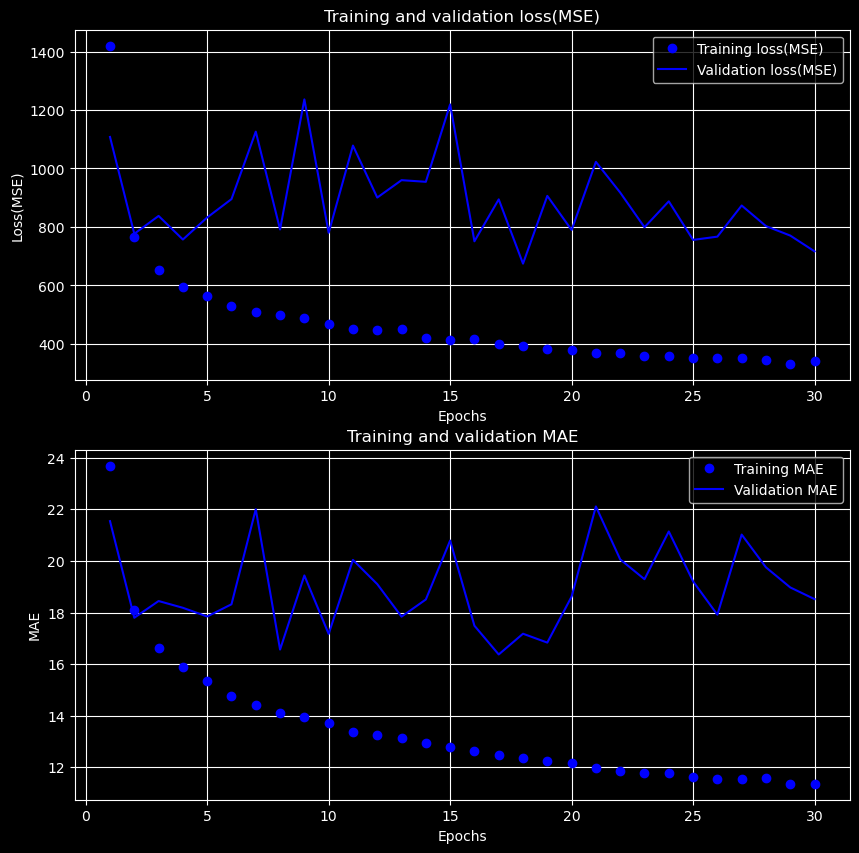

In [273]:
plot_history(history)

In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2 ,epochs=50,
          batch_size=16)
plot_history(history)


In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2,
                    epochs=100, batch_size=16)
plot_history(history)
